In [11]:
from environment import Maze

from RL_brain import QLearningTable
import numpy as np

env = Maze()
RL = QLearningTable(actions=list(range(env.n_actions)))



def give_me_fidelity(N):

    dt     = 2 * np.pi/N   
    ep_max = 500
    fidelity=np.zeros(ep_max)

    RL       = QLearningTable(actions=list(range(env.n_actions)))

    fid_10 = 0
    for episode in range(ep_max):
        observation = env.reset()
        while True:
            
            action = RL.choose_action(str(observation))    
            observation_, reward, done, fid = env.step(action)
            RL.learn(str(observation), action, reward, str(observation_))
            observation = observation_
            if done:
                if episode >= ep_max-11:
                    fid_10 = max(fid_10,fid)
                break
                
    print('Final_fidelity for QL for  {N} '.format(N=N),fid_10)

    return fid_10



In [12]:
import numpy as np
from scipy.linalg import expm

from matplotlib import pyplot as plt


def calculate_cost(sequence):

    length = len(sequence) 
    time_step = 2*np.pi/length  

    sigma_x = 1/2 * np.mat([[0,1],\
                 [1,0]], dtype=complex)
    sigma_z = 1/2 * np.mat([[1,0],\
                 [0,-1]], dtype=complex)

    evolution_operator = np.matrix(np.identity(2, dtype=complex)) # Initial Evolution operator

    control_strength = 4  # Control field strength

    for action in sequence:
        hamiltonian = action * control_strength * sigma_z + 1*sigma_x # Hamiltonian
        evolution_operator = expm(-1j * hamiltonian * time_step) * evolution_operator  # Evolution operator

    initial_state = np.mat([[1],[0]], dtype=complex) # Initial state
    final_state = evolution_operator * initial_state  # Final state

    target_state = np.mat([[0], [1]], dtype=complex)                             # Target state (south pole)

    error = 1 - (np.abs(final_state.H * target_state)**2).item(0).real  # Infidelity (to minimize)

    return error


step_size = 0.01
cost_history = []

def gradient_descent(sequence, dimension, learning_rate, num_iterations):
    for _ in range(num_iterations):
        random_vector = np.random.rand(dimension) 
        sequence_plus = sequence + random_vector * step_size
        sequence_minus = sequence - random_vector * step_size
        error_derivative = (calculate_cost(sequence_plus) - calculate_cost(sequence_minus)) / (2 * step_size)
        sequence = sequence - (learning_rate) * error_derivative * random_vector
        cost_history.append(calculate_cost(sequence_plus))
        # print(calculate_cost(sequence))


    return calculate_cost(sequence)


def sgd(N):

    sequence_length = N
    random_sequence = np.random.rand(sequence_length)
    max_epochs = 500
    final_fidelity = 1 - gradient_descent(random_sequence, sequence_length, 0.01, max_epochs)

    print('Final Fidelity for sgd for {N}:'.format(N=sequence_length), final_fidelity)

    return final_fidelity


In [13]:
fid_list_QL=[]
fid_list_sgd=[]

for i in range(1,50,5):
    fid_list_QL.append(give_me_fidelity(i))
    fid_list_sgd.append(sgd(i))


    

Final_fidelity for QL for  1  0.3823495489593384
Final Fidelity for sgd for 1: 0.1626513246614859
Final_fidelity for QL for  6  0.5682577856362999
Final Fidelity for sgd for 6: 0.8444667672870947
Final_fidelity for QL for  11  0.42679573692015904
Final Fidelity for sgd for 11: 0.9650624725364977
Final_fidelity for QL for  16  0.6635445456166651
Final Fidelity for sgd for 16: 0.2684616154564956
Final_fidelity for QL for  21  0.5337901663553813
Final Fidelity for sgd for 21: 0.1927622385010056
Final_fidelity for QL for  26  0.34823161442186606
Final Fidelity for sgd for 26: 0.750570761560018
Final_fidelity for QL for  31  0.5904923991202087
Final Fidelity for sgd for 31: 0.24468706740785562
Final_fidelity for QL for  36  0.6199149938942571
Final Fidelity for sgd for 36: 0.06975401660308855
Final_fidelity for QL for  41  0.49361460099489035
Final Fidelity for sgd for 41: 0.18877333834749233
Final_fidelity for QL for  46  0.6778043915616487
Final Fidelity for sgd for 46: 0.2175251001020223

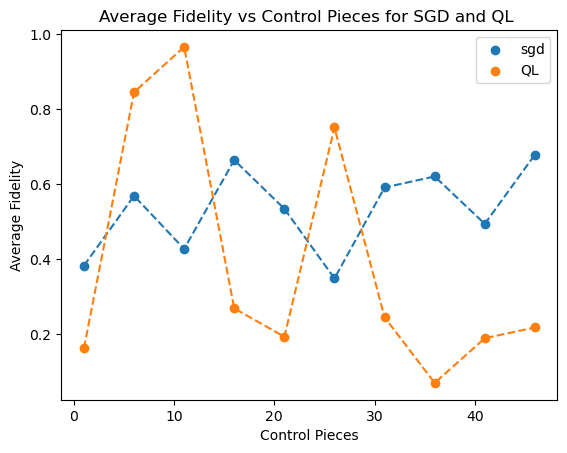

In [14]:

x=[i for i in range(1,50,5)]
plt.scatter(x,fid_list_QL,label="sgd")
plt.plot(x,fid_list_QL,"--")
plt.scatter(x,fid_list_sgd,label="QL")
plt.plot(x,fid_list_sgd,"--")

plt.legend()
plt.xlabel("Control Pieces")
plt.ylabel("Average Fidelity")
plt.title("Average Fidelity vs Control Pieces for SGD and QL ")
plt.show()